# Grupo 9

# Integrantes:
   #### Agustin Galli
   #### Gaston Bruno 
   #### Juan Manuel 
   #### Pedro Terrado
   #### Facundo Blanco

### Dataset: Fifa 19

# Objetivo
#### El objetivo del presente desafío es predecir la mejor posición de un jugador de fútbol mediante sus skills y diferentes cualidades.

# Importamos librerias 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

#### Libreria instalada por fuera para realizar algunos gráficos

In [2]:
#pip install yellowbrick

# Importamos Archivo

In [3]:
df = pd.read_csv("data.csv", sep=",",index_col='Unnamed: 0')
df.shape

(18207, 88)

# Limpieza del archivo

In [4]:
df = df.drop(['ID','Photo','Flag','Club Logo','Real Face','Jersey Number','Loaned From']
, axis=1)

In [5]:
df['Posicion'] = df['Position']

In [6]:
def posiciones(x):
    if (x == 'GK'):
        return 'Arquero'
    elif ((x == 'RB') | (x == 'LB') | (x == 'CB') | (x == 'LCB') | (x == 'RCB') | (x == 'RWB') | (x == 'LWB') ):
        return 'Defensor'
    elif ((x == 'LDM') | (x == 'CDM') | (x == 'RDM') | (x == 'LM') | (x == 'LCM') | (x == 'CM') | (x == 'RCM') | (x == 'RM') | (x == 'LAM') | (x == 'CAM') | (x == 'RAM') | (x == 'LW') | (x == 'RW')):
        return 'Volante'
    elif ((x == 'RS') | (x == 'ST') | (x == 'LS') | (x == 'CF') | (x == 'LF') | (x == 'RF')):
        return 'Delantero'

In [7]:
df['Position2'] = df.Position.apply(lambda x: posiciones(x))

In [8]:
df = df.drop(['Posicion', 'Joined', 'LS', 'ST', 'RS',
       'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM',
       'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB',
       'RCB', 'RB', 'Contract Valid Until'], axis= 1)

In [9]:
df = df.dropna()

In [10]:
dummy = pd.get_dummies(df['Position2'])
df = pd.concat([df, dummy], axis=1)

### Limpio datos numericos

#### Peso

In [11]:
df['Weight'] = df['Weight'].str.replace('lbs','')
df['Weight'] = df['Weight'].astype(np.int)

In [12]:
## Paso a kilos
def weight_conversion(Value):
    out = Value *  0.453592
    return float(round(out,1))


In [13]:
df['Weight'] = df['Weight'].astype(np.float)
df['Weight2'] = df['Weight'].apply(lambda x: weight_conversion(x))

#### Valores Numericos

In [14]:
def conversion_Numeros(Value):
    if isinstance(Value,str):
        out = Value.replace('€', '')
        if 'M' in out:
            out = float(out.replace('M', ''))*1000000
        elif 'K' in Value:
            out = float(out.replace('K', ''))*1000
        return float(out)


df['Value2'] = df['Value'].apply(lambda x: conversion_Numeros(x))
df['Wage2'] = df['Wage'].apply(lambda x: conversion_Numeros(x))

#### Sueldo

In [15]:
def sueldo_categoria(value):
    if value < 1000:
        out = 'Bajo'
    elif value < 2501:
        out = 'Bajo-Medio'
    elif value < 5001:
        out = 'Medio'
    elif value < 15001:
        out = 'Medio-Alto'
    elif value < 55000:
        out = 'Alto'        
    else:
        out = 'Estrella'
    return out


In [16]:
df['Wage_rank'] = df['Wage2'].apply(lambda x: sueldo_categoria(x))
df['Wage_rank'].head(100)

0      Estrella
1      Estrella
2      Estrella
3      Estrella
4      Estrella
         ...   
98     Estrella
99     Estrella
100    Estrella
101    Estrella
102        Alto
Name: Wage_rank, Length: 100, dtype: object

#### Altura

In [17]:
df['Height'] = df['Height'].str.replace("'",".")
df['Height'] = df['Height'].str.replace(",",".")
df['Height'] = df['Height'].astype(np.float)

In [18]:
def height_conversion(Value):
    out = (Value//1) * 30.48 + (Value%1) * 10 * 2.54
    return float(out)


In [19]:
df['Height2'] = df['Height'].apply(lambda x: height_conversion(x))

In [20]:
dummy = pd.get_dummies(df['Preferred Foot'],drop_first=True, prefix = 'Foot_')
df = pd.concat([df, dummy], axis=1)

# Modelos

#### Seleccionamos las columnas features y la variable target

In [21]:
# Columnas reducidas para ver como perfecciona
train_cols = ['Weight2','Height2','Overall', 'Special', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy','LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength','LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKHandling', 'GKReflexes']
X = df[train_cols]
y = df['Position2']

In [ ]:
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X, y, stratify=y, random_state=12)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=12)

In [52]:
# Estanadarizamos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Naive-Bayes
#### Score = 0.78

In [32]:
model = MultinomialNB()
model.fit(X_train_n, y_train_n)

MultinomialNB()

In [33]:
model.score(X_test_n, y_test_n)

0.7837058399423216

In [34]:
model.classes_

array(['Arquero', 'Defensor', 'Delantero', 'Volante'], dtype='<U9')

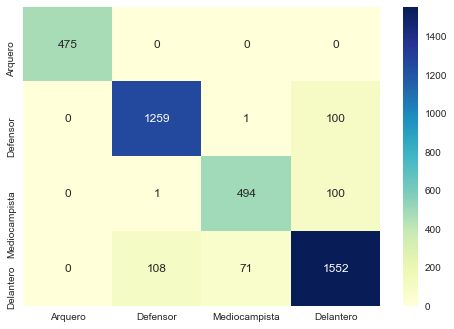

In [50]:
conf_mat_Naive = confusion_matrix(y_test_n, y_pred_n)
conf_mat_Naive_df = pd.DataFrame(data=conf_mat_Naive, 
                           index=['Arquero', 'Defensor','Mediocampista','Delantero'], 
                           columns=['Arquero', 'Defensor','Mediocampista','Delantero'])

sns.heatmap(conf_mat_Naive_df, annot=True, fmt='d', cmap='YlGnBu');

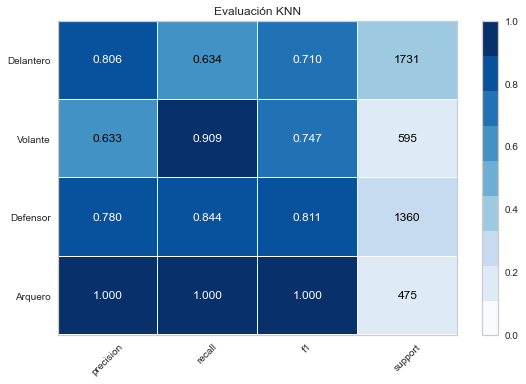

<AxesSubplot:title={'center':'Evaluación KNN'}>

In [47]:
model = MultinomialNB()
classes = ['Arquero','Defensor','Volante', 'Delantero']
visualizer = ClassificationReport(model,classes=['Arquero','Defensor','Volante', 'Delantero'], support=True,  title='Evaluación KNN', cmap= 'Blues')

visualizer.fit(X_train_n, y_train_n)        
visualizer.score(X_test_n, y_test_n)    
visualizer.show()   

## KNN
#### Score = 0.903

In [53]:
# Instanciamos el modelo con su configuración por defecto
knn = KNeighborsClassifier(n_neighbors=20)
# Ajustamos a los datos de entrenamiento
knn.fit(X_train, y_train)
# Predecimos etiquetas para los datos de test
y_pred = knn.predict(X_test)
# Evaluamos el accuracy del modelo
accuracy_score(y_test, y_pred).round(3)

0.903

In [26]:
folds=StratifiedKFold(n_splits=10, random_state=19, shuffle=True)
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=folds, scoring='accuracy')
    k_scores.append(scores.mean())
k_scores

[0.8484216219129148,
 0.8417730338116647,
 0.8775847601157849,
 0.8783057856541643,
 0.8855161051918458,
 0.8862371948841125,
 0.8905627707294042,
 0.8916843731395373,
 0.894408924575558,
 0.8933670654472297,
 0.8936877707294041,
 0.8956904626265116,
 0.89520905185687,
 0.895769820984993,
 0.8944081547289114,
 0.8951291802672907,
 0.8948083466773419,
 0.8959304623185729,
 0.8942475133953316,
 0.8960907187288292,
 0.8956098853441727,
 0.8958504624212191,
 0.8943278340621216,
 0.8965711030362753,
 0.8955298212929318,
 0.8960909111904908,
 0.8952895649853216,
 0.8964914880622444,
 0.8953696290365626,
 0.8958505907289934]

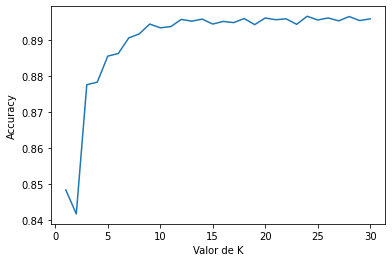

In [27]:
plt.plot(k_range, k_scores)
plt.xlabel('Valor de K')
plt.ylabel('Accuracy');

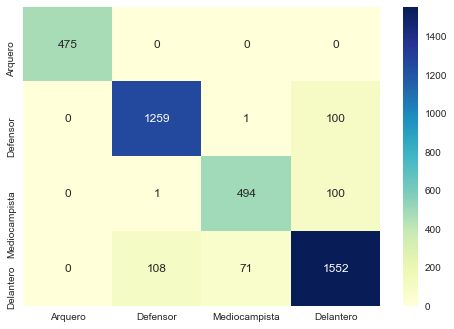

In [48]:
conf_mat_knn = confusion_matrix(y_test, y_pred)
conf_mat_knn_df = pd.DataFrame(data=conf_mat_knn, 
                            index=['Arquero', 'Defensor','Mediocampista','Delantero'], 
                           columns=['Arquero', 'Defensor','Mediocampista','Delantero'])
sns.heatmap(conf_mat_knn_df, annot=True, fmt='d', cmap='YlGnBu');

In [33]:
confusion_matrix(y_test, y_pred)

array([[ 475,    0,    0,    0],
       [   0, 1233,    1,  126],
       [   0,    1,  492,  102],
       [   0,  102,   72, 1557]], dtype=int64)

#### Libreria utilizada para la matríz de confusión

In [37]:
##pip install yellowbrick
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC


  Using cached yellowbrick-1.3.post1-py3-none-any.whl (271 kB)


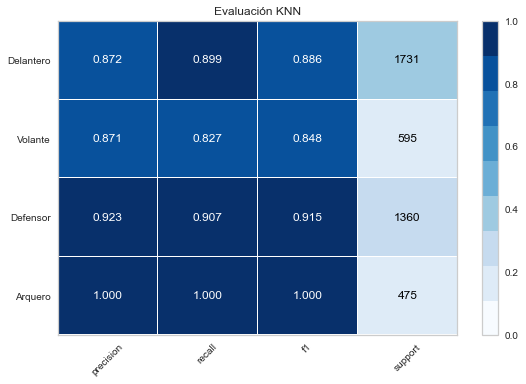

<AxesSubplot:title={'center':'Evaluación KNN'}>

In [26]:

model = KNeighborsClassifier(n_neighbors=20)
classes = ['Arquero','Defensor','Volante', 'Delantero']
visualizer = ClassificationReport(model,classes=['Arquero','Defensor','Volante', 'Delantero'], support=True,  title='Evaluación KNN', cmap= 'Blues')

visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.show()                       

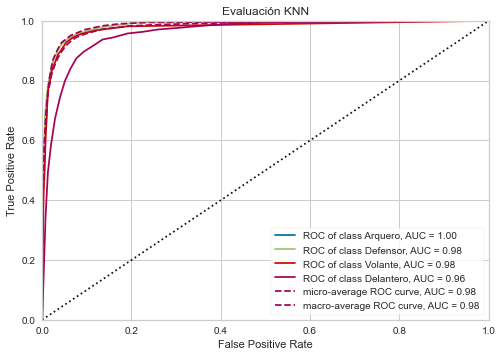

<AxesSubplot:title={'center':'Evaluación KNN'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [27]:
model = KNeighborsClassifier(n_neighbors=20)
classes = ['Arquero','Defensor','Volante', 'Delantero']
visualizer = ROCAUC(model,classes=['Arquero','Defensor','Volante', 'Delantero'], support=True,  title='Evaluación KNN', cmap= 'Blues')

visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.show()        

## Regresión Logística
#### Score =  0.91

In [36]:
clf = LogisticRegression(C=1e10,solver='lbfgs')

In [37]:
clf.fit(X_train, y_train)

C:\Users\gbruno\Anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10000000000.0)

In [38]:
y_pred = clf.predict(X_test)

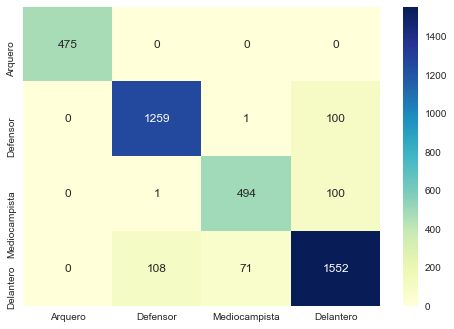

In [49]:
conf_mat_reglog = confusion_matrix(y_test, y_pred)
conf_mat_reglog_df = pd.DataFrame(data=conf_mat_reglog, 
                            index=['Arquero', 'Defensor','Mediocampista','Delantero'], 
                           columns=['Arquero', 'Defensor','Mediocampista','Delantero'])
sns.heatmap(conf_mat_reglog_df, annot=True, fmt='d', cmap='YlGnBu');

In [42]:
print('Accuracy=', accuracy_score(y_test, y_pred).round(2))

Accuracy= 0.91


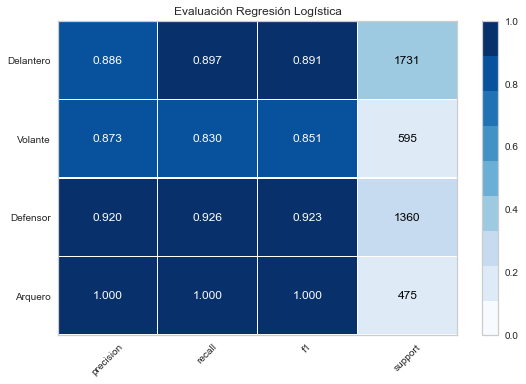

<AxesSubplot:title={'center':'Evaluación Regresión Logística'}>

In [46]:
classes = ['Arquero','Defensor','Volante', 'Delantero']
visualizer = ClassificationReport(clf,classes=['Arquero','Defensor','Volante', 'Delantero'], support=True,  title='Evaluación Regresión Logística', cmap= 'Blues')

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()        

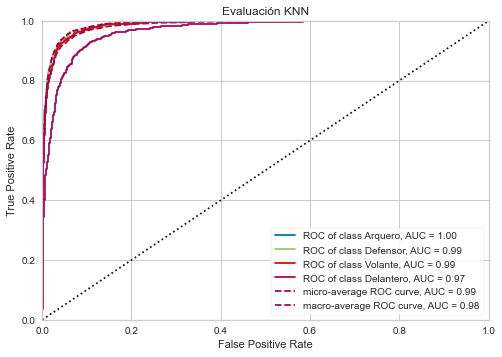

<AxesSubplot:title={'center':'Evaluación KNN'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [44]:

classes = ['Arquero','Defensor','Volante', 'Delantero']
visualizer = ROCAUC(clf,classes=['Arquero','Defensor','Volante', 'Delantero'], support=True,  title='Evaluación Regresión Logística', cmap= 'Blues')

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()       

# Clustering

In [42]:
from sklearn.cluster import KMeans,DBSCAN
from scipy.cluster import hierarchy 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score,calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist,squareform
from sklearn.decomposition import PCA


In [43]:
df.columns

Index(['Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Value',
       'Wage', 'Special', 'Preferred Foot', 'International Reputation',
       'Weak Foot', 'Skill Moves', 'Work Rate', 'Body Type', 'Position',
       'Height', 'Weight', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'Release Clause', 'Position2', 'Arquero', 'Defensor', 'Delantero',
       'Volante', 'Value2', 'Wage2', 'Wage_rank', 'Height2', 'Weight2',
       'Foot__Right'],
      dtype='object')

In [44]:
df_cl =  df

In [45]:
dummy = pd.get_dummies(df_cl['Wage_rank'])
df_cl = pd.concat([df_cl, dummy], axis=1)


In [152]:
# Preparamos el dataset para clustering
data_clustering = df[['Overall', 'Special',
       'Weak Foot', 'Skill Moves', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy','LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength','LongShots', 'Interceptions', 'Vision',
       'Penalties', 'Composure', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes'
                     ,'Height2', 'Weight2']]

In [153]:
# Convertimos las columnas a numerico y eliminamos las filas conflictivas

object_columns=[col for col in data_clustering.columns if df[col].dtype=='object']

mask=data_clustering[object_columns].applymap(lambda x:  not str(x).isnumeric())
data_clustering=data_clustering.drop(data_clustering[mask.sum(axis=1)>0].index,axis=0)


In [154]:
scaler=StandardScaler()
X=scaler.fit_transform(data_clustering)

inertia=[]
sil=[]
ch_scores=[]
k_values=range(2,20,2)

for k in k_values:
    print(k)
    km=KMeans(n_clusters=k)
    km.fit(X)
    inertia.append(km.inertia_)    

2
4
6
8
10
12
14
16
18


Text(0, 0.5, 'Inertia')

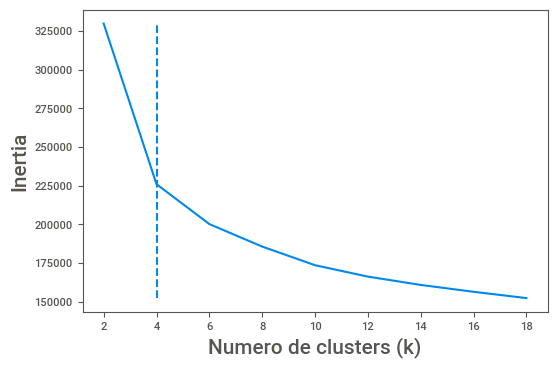

In [155]:
plt.plot(k_values,inertia);
plt.vlines(4,np.min(inertia),np.max(inertia),linestyle='dashed');
plt.xlabel('Numero de clusters (k)',fontsize=15);plt.ylabel('Inertia',fontsize='15')

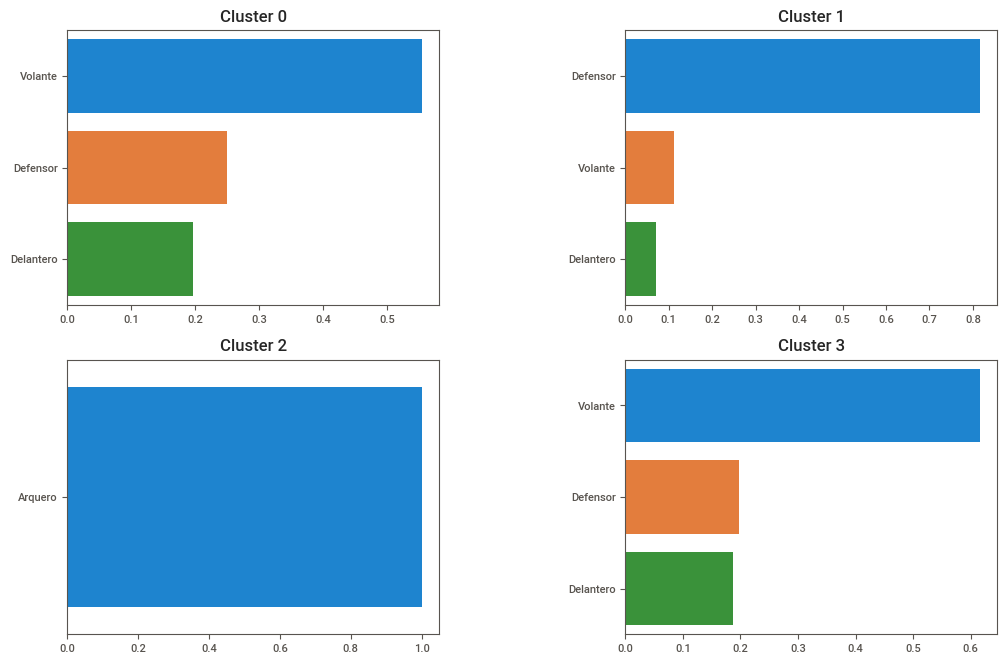

In [156]:
k=4;
km=KMeans(n_clusters=k,random_state=0)
km.fit(X)

data_filtered=df.loc[data_clustering.index];
f,ax=plt.subplots(2,2,figsize=(12,8),gridspec_kw={'wspace':0.5})
ax=ax.ravel();
for lbl in range(k):
    S=data_filtered.loc[km.labels_==lbl,'Position2'].value_counts(normalize=True);
    chart=sns.barplot(y=S.index[:10],x=S.values[:10],ax=ax[lbl],orient='h')
    chart.set_title('Cluster '+str(lbl))


evaluation = []
for k in range(2,9):
    kmeans = KMeans(n_clusters=k, random_state=0) 
    kmeans.fit(X)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    #predY = np.choose(labels, pd.Series(range(0,k+1)).astype(np.int64))
    silhouette = silhouette_score(X, labels, metric='euclidean')
    calinsky = calinski_harabasz_score(X, labels)      
    evaluation.append([k, silhouette, calinsky])
    #print("K= ", evaluation)

evaluation=np.array(evaluation);
f,ax=plt.subplots(1,2,figsize=(15,6))
ax[0].plot(evaluation[:,0],evaluation[:,1]) 
ax[0].set_ylabel('Silhouette Score')
ax[0].set_xlabel('Número de clusters')

ax[1].plot(evaluation[:,0],evaluation[:,2]) 
ax[1].set_ylabel('Calinski-Harabasz Score')    
ax[1].set_xlabel('Número de clusters');


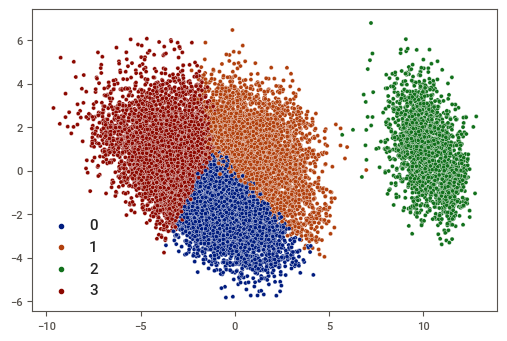

In [157]:
k=4;
km=KMeans(n_clusters=k,random_state=0)
km.fit(X)
pca=PCA(n_components=2)
X_transformed=pca.fit_transform(X)
sns.scatterplot(x = X_transformed[:,0], y = X_transformed[:,1],hue=km.labels_,palette='dark');
plt.savefig('Clustering KNN.jpg')

### Dendrograma

In [55]:
from scipy.cluster import hierarchy 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

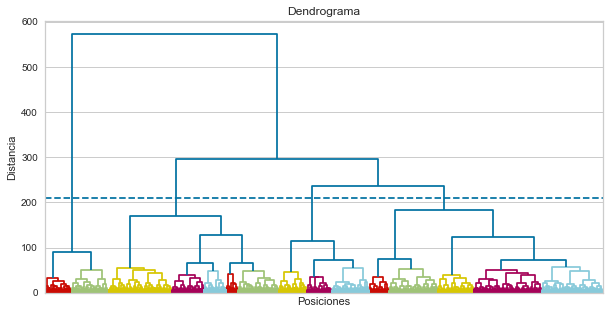

In [56]:
Z = linkage(X_train, 'ward');

plt.figure(figsize=[10,5])
plt.title('Dendrograma')
plt.xlabel('Posiciones')
plt.ylabel('Distancia')

color_palette=['r','g','y','m','c'];

hierarchy.set_link_color_palette(color_palette) 

dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=5.,  
    color_threshold=60,     
)
plt.hlines(210,0,X_train.shape[0]*100,linestyle='--')
plt.xticks([])
plt.show()

# Conclusiones

##### Despues de haber realizados los 3 modelos determinamos que el que mejor performa es el de Regresión Logística. De todas maneras, todos los modelos tienen una muy buena performance debido a la cantidad de datos disponibles y a la cantidad de columnas específicas que describen la posición de un jugador. Por ejemplo tenemos cerca de 10 columnas que son cualidades exclusivas de los arqueros, es por tal motivo que en esa categoria no tenemos errores. 
##### Igualmente creemos que es posible seguir investigando los datos y acortar la cantidad de features que tenemos para ajustarnos a la realidad. Con tan solo algunas columnas claves se podría llegar a armar un modelo donde un entrenador de juveniles pueda cargar la puntuacion de ciertas cualidades y el modelo prediga la mejor posición para ese jugador.